In [15]:
# Basic imports and environment checks
import os
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Path("results/text_conditioning_run/samples").mkdir(parents=True, exist_ok=True)
Path("results/text_conditioning_run/checkpoints").mkdir(parents=True, exist_ok=True)


PyTorch: 2.6.0+cu124 | CUDA: True


In [16]:
# Uncomment if running in a fresh kernel
# !pip install transformers sentence-transformers medmnist

from transformers import AutoTokenizer, AutoModel
import medmnist
from medmnist import INFO, PathMNIST


In [17]:
class CFG:
    dataset = "PathMNIST"
    img_size = 28
    batch_size = 64
    epochs = 15
    timesteps = 400
    lr = 2e-4
    base_ch = 32
    save_every = 300
    device = device
    output_dir = Path("results/text_conditioning_run")

cfg = CFG()

# Example conditioning texts (short labels or short descriptions)
text_prompts = [
    "adenocarcinoma tissue with glandular formations",
    "normal epithelial cells, organized",
    "highly cellular tumor region",
    "necrotic tissue region"
]


In [18]:
# Choose a biomedical LM. Uncomment the one you want.
# BioBERT:
LM_NAME = "dmis-lab/biobert-v1.1"               # BioBERT
# PubMedBERT:
# LM_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"  # PubMedBERT

tokenizer = AutoTokenizer.from_pretrained(LM_NAME)
text_encoder = AutoModel.from_pretrained(LM_NAME).to(cfg.device)
text_encoder.eval()  # we use frozen embeddings for now (no finetune)


c:\Users\saira\anaconda3\envs\matsuo\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
@torch.no_grad()
def encode_texts(prompts, max_length=32):
    inputs = tokenizer(prompts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs = {k: v.to(cfg.device) for k,v in inputs.items()}
    out = text_encoder(**inputs, return_dict=True)
    # Use mean pooling over tokens from last_hidden_state (or use pooled_output if available)
    if hasattr(out, "pooler_output") and out.pooler_output is not None:
        emb = out.pooler_output  # (batch, hidden)
    else:
        # mean pooling
        token_emb = out.last_hidden_state  # (B, L, H)
        attn_mask = inputs["attention_mask"].unsqueeze(-1)
        emb = (token_emb * attn_mask).sum(dim=1) / attn_mask.sum(dim=1).clamp(min=1e-9)
    return emb  # (B, H)

# quick check
sample_emb = encode_texts([text_prompts[0]])
print("Text embedding shape:", sample_emb.shape)


Text embedding shape: torch.Size([1, 768])


In [20]:
# Reuse model building blocks but add FiLM in the bottleneck (mid)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.AvgPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class FiLMMid(nn.Module):
    def __init__(self, feat_ch, text_emb_dim):
        super().__init__()
        # produce gamma and beta of shape (feat_ch)
        self.mlp = nn.Sequential(
            nn.Linear(text_emb_dim, text_emb_dim//2),
            nn.SiLU(),
            nn.Linear(text_emb_dim//2, feat_ch*2)  # gamma and beta
        )
    def forward(self, x, text_emb):
        # x: (B, C, H, W), text_emb: (B, H_t)
        params = self.mlp(text_emb)  # (B, 2*C)
        gamma, beta = params.chunk(2, dim=-1)
        gamma = gamma.view(-1, x.size(1), 1, 1)
        beta  = beta.view(-1, x.size(1), 1, 1)
        return x * (1 + gamma) + beta

class TinyUNetFiLM(nn.Module):
    def __init__(self, channels=1, base_ch=32, text_emb_dim=768):
        super().__init__()
        self.inc = DoubleConv(channels, base_ch)
        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.mid = DoubleConv(base_ch*4, base_ch*4)
        self.film = FiLMMid(base_ch*4, text_emb_dim)
        self.up2 = Up(base_ch*4, base_ch*2)
        self.up1 = Up(base_ch*2, base_ch)
        self.outc = nn.Conv2d(base_ch, channels, 1)
    def forward(self, x, text_emb=None):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        xm = self.mid(x3)
        if text_emb is not None:
            xm = self.film(xm, text_emb)
        xu = self.up2(xm)
        xu = xu + x2
        xu = self.up1(xu)
        xu = xu + x1
        out = self.outc(xu)
        return out


In [21]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, timesteps)

class Diffusion:
    def __init__(self, timesteps=1000, device='cpu'):
        self.timesteps = timesteps
        self.device = device
        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        a_hat = self.alpha_hat[t].view(-1,1,1,1)
        sqrt_a = a_hat.sqrt()
        sqrt_om = (1 - a_hat).sqrt()
        return sqrt_a * x_start + sqrt_om * noise


In [22]:
transform = T.Compose([T.Resize((cfg.img_size, cfg.img_size)), T.ToTensor()])
train_ds = PathMNIST(split='train', transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
DataClass = PathMNIST if cfg.dataset == "PathMNIST" else OrganAMNIST
info = INFO[cfg.dataset.lower()]


In [23]:
text_emb_dim = sample_emb.shape[-1]  # hidden size from LM
channels = 1 if info['n_channels'] == 1 else 3
model = TinyUNetFiLM(channels=channels, base_ch=cfg.base_ch, text_emb_dim=text_emb_dim).to(cfg.device)
diffusion = Diffusion(timesteps=cfg.timesteps, device=cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)


Model params (M): 1.116355


In [24]:
step = 0
loss_hist = []
prompts = text_prompts  # cycle through these for conditioning in the demo

for epoch in range(cfg.epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs}")
    for batch in pbar:
        imgs, labels = batch[0].to(cfg.device), batch[1].to(cfg.device)
        imgs = imgs.float()
        imgs = imgs * 2. - 1.0  # [-1,1]
        bsz = imgs.shape[0]

        # randomly pick conditioning text for each sample in the batch (demo)
        # For reproducibility, we'll tile a small set:
        txts = [prompts[i % len(prompts)] for i in range(bsz)]
        text_emb = encode_texts(txts)  # (B, H)
        
        t = torch.randint(0, cfg.timesteps, (bsz,), device=cfg.device).long()
        noise = torch.randn_like(imgs)
        x_t = diffusion.q_sample(imgs, t, noise=noise)

        pred_noise = model(x_t, text_emb)  # conditioned prediction
        loss = nn.MSELoss()(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step += 1
        loss_hist.append(float(loss.detach().cpu()))
        pbar.set_postfix(loss=float(loss.detach().cpu()))

        # save conditioned samples periodically
        if step % cfg.save_every == 0:
            model.eval()
            with torch.no_grad():
                n = min(8, imgs.size(0))
                # make sure we always have exactly n prompts (wrap if necessary)
                chosen_prompts = [prompts[i % len(prompts)] for i in range(n)]
                text_emb_sample = encode_texts(chosen_prompts).to(cfg.device)
                # sanity check
                assert text_emb_sample.size(0) == n, f"text_emb_sample has batch {text_emb_sample.size(0)} but expected {n}"

                z = torch.randn(n, imgs.size(1), cfg.img_size, cfg.img_size, device=cfg.device)
                x = z

                # sampling loop
                for time_step in reversed(steps_to_run):
                    pred_n = model(x, text_emb_sample)
                    coef = diffusion.betas[time_step].sqrt().to(x.device)
                    x = (x - coef * pred_n)
                    x = x.clamp(-1,1)

                samples = (x + 1) / 2.0
                grid = make_grid(samples.cpu(), nrow=4)
                save_image(grid, cfg.output_dir / "samples" / f"text_step_{step}.png")

                # also save text->image pairs as individual files and a small overlay grid
                print("Saved conditioned samples at step", step)
            model.train()
    # end epoch

print("Training complete. Steps:", step)


Epoch 1/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 300
Saved conditioned samples at step 600
Saved conditioned samples at step 900
Saved conditioned samples at step 1200


Epoch 2/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 1500
Saved conditioned samples at step 1800
Saved conditioned samples at step 2100
Saved conditioned samples at step 2400
Saved conditioned samples at step 2700


Epoch 3/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 3000
Saved conditioned samples at step 3300
Saved conditioned samples at step 3600
Saved conditioned samples at step 3900
Saved conditioned samples at step 4200


Epoch 4/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 4500
Saved conditioned samples at step 4800
Saved conditioned samples at step 5100
Saved conditioned samples at step 5400


Epoch 5/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 5700
Saved conditioned samples at step 6000
Saved conditioned samples at step 6300
Saved conditioned samples at step 6600
Saved conditioned samples at step 6900


Epoch 6/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 7200
Saved conditioned samples at step 7500
Saved conditioned samples at step 7800
Saved conditioned samples at step 8100
Saved conditioned samples at step 8400


Epoch 7/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 8700
Saved conditioned samples at step 9000
Saved conditioned samples at step 9300
Saved conditioned samples at step 9600


Epoch 8/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 9900
Saved conditioned samples at step 10200
Saved conditioned samples at step 10500
Saved conditioned samples at step 10800
Saved conditioned samples at step 11100


Epoch 9/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 11400
Saved conditioned samples at step 11700
Saved conditioned samples at step 12000
Saved conditioned samples at step 12300
Saved conditioned samples at step 12600


Epoch 10/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 12900
Saved conditioned samples at step 13200
Saved conditioned samples at step 13500
Saved conditioned samples at step 13800


Epoch 11/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 14100
Saved conditioned samples at step 14400
Saved conditioned samples at step 14700
Saved conditioned samples at step 15000
Saved conditioned samples at step 15300


Epoch 12/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 15600
Saved conditioned samples at step 15900
Saved conditioned samples at step 16200
Saved conditioned samples at step 16500
Saved conditioned samples at step 16800


Epoch 13/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 17100
Saved conditioned samples at step 17400
Saved conditioned samples at step 17700
Saved conditioned samples at step 18000


Epoch 14/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 18300
Saved conditioned samples at step 18600
Saved conditioned samples at step 18900
Saved conditioned samples at step 19200
Saved conditioned samples at step 19500


Epoch 15/15:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved conditioned samples at step 19800
Saved conditioned samples at step 20100
Saved conditioned samples at step 20400
Saved conditioned samples at step 20700
Saved conditioned samples at step 21000
Training complete. Steps: 21105


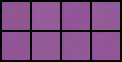

Displayed: results\text_conditioning_run\samples\text_step_21000.png
Prompts used (example):
1. adenocarcinoma tissue with glandular formations
2. normal epithelial cells, organized
3. highly cellular tumor region
4. necrotic tissue region


In [27]:
# Show the last saved sample image and corresponding prompts
samples_dir = cfg.output_dir / "samples"
imgs = sorted(list(samples_dir.glob("*.png")), key=os.path.getmtime) if samples_dir.exists() else []
if imgs:
    last = imgs[-1]
    from PIL import Image, ImageDraw, ImageFont
    im = Image.open(last).convert("RGB")
    display(im)
    print("Displayed:", last)
    print("Prompts used (example):")
    for i, p in enumerate(text_prompts[:8]):
        print(f"{i+1}. {p}")
else:
    print("No generated samples found.")


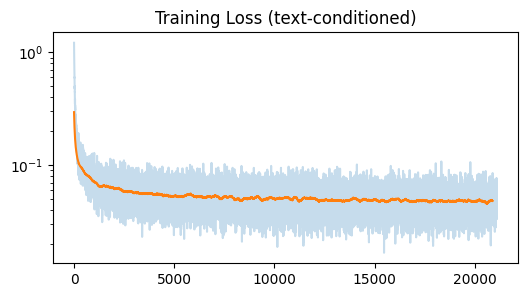

In [28]:
import numpy as np
if len(loss_hist) > 0:
    window = max(1, len(loss_hist)//100)
    sm = np.convolve(loss_hist, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(6,3))
    plt.plot(loss_hist, alpha=0.25)
    plt.plot(sm, linewidth=1.5)
    plt.title('Training Loss (text-conditioned)')
    plt.yscale('log')
    plt.show()
else:
    print("No loss history.")
